<a href="https://colab.research.google.com/github/bnanik/Fine-tuning-BERT-for-text-classification/blob/main/Fine_Tune_BERT_for_Text_Classification_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

In this [project](https://www.coursera.org/projects/fine-tune-bert-tensorflow/), I learned how to fine-tune a BERT model for text classification using TensorFlow and TF-Hub.

The pretrained BERT model used in this project is [available](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) on [TensorFlow Hub](https://tfhub.dev/).

### Objectives


- Build TensorFlow Input Pipelines for Text Data with the [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) API
- Tokenize and Preprocess Text for BERT
- Fine-tune BERT for text classification with TensorFlow 2 and [TF Hub](https://tfhub.dev)

### Contents

This notebook consists of several Tasks.

- **[Step 1]()**: Introduction to the Project.
- **[Step 2]()**: Setup your TensorFlow and Colab Runtime
- **[Step 3]()**: Download and Import the Quora Insincere Questions Dataset
- **[Step 4]()**: Create tf.data.Datasets for Training and Evaluation
- **[Step 5]()**: Download a Pre-trained BERT Model from TensorFlow Hub
- **[Step 6]()**: Tokenize and Preprocess Text for BERT
- **[Step 7]()**: Wrap a Python Function into a TensorFlow op for Eager Execution
- **[Step 8]()**: Create a TensorFlow Input Pipeline with `tf.data`
- **[Step 9]()**: Add a Classification Head to the BERT `hub.KerasLayer`
- **[Step 10]()**: Fine-Tune BERT for Text Classification
- **[Step 11]()**: Evaluate the BERT Text Classification Model

## Step 2: Setup your TensorFlow and Colab Runtime.

In [33]:
!nvidia-smi

Sat Sep 17 14:27:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    32W /  70W |    798MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install TensorFlow and TensorFlow Model Garden

In [34]:
import tensorflow as tf
print(tf.version.VERSION)

2.8.2


In [36]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [37]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# we may have to restart the runtime afterwards

## Step 3: Download and Import the Quora Insincere Questions Dataset

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [2]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.8.2
Eager mode:  True
Hub version:  0.12.0
GPU is available


A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip', compression='zip', low_memory=False)
df.shape


(1306122, 3)

In [4]:
df.tail(20)

,qid,question_text,target
1306102,ffff3778790af9baae76,What steps can I take to live a normal life if...,0
1306103,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1
1306104,ffff41393389d4206066,Is 33 too late for a career in creative advert...,0
1306105,ffff42493fc203cd9532,What is difference between the filteration wor...,0
1306106,ffff48dd47bee89fff79,"If the universe ""popped"" into existence from n...",0
1306107,ffff5fd051a032f32a39,How does a shared service technology team meas...,0
1306108,ffff6d528040d3888b93,How is DSATM civil engineering?,0
1306109,ffff8776cd30cdc8d7f8,Do you know any problem that depends solely on...,0
1306110,ffff94d427ade3716cd1,What are some comic ideas for you Tube videos ...,0
1306111,ffffa382c58368071dc9,"If you had $10 million of Bitcoin, could you s...",0


<AxesSubplot:title={'center':'Target distribution'}, ylabel='Frequency'>

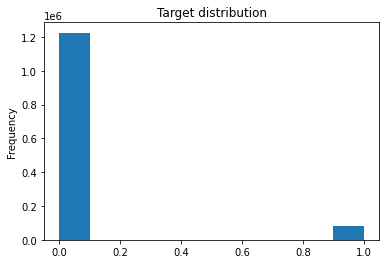

In [5]:
df.target.plot(kind='hist', title='Target distribution')

## Step 4: Create tf.data.Datasets for Training and Evaluation

In [6]:
train_df, remaining = train_test_split(df, random_state=42, train_size=0.0075, stratify=df.target.values)
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.00075, stratify=remaining.target.values)
train_df.shape, valid_df.shape


((9795, 3), (972, 3))

In [7]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.question_text.values, valid_df.target.values))

  for text, label in train_data.take(1):
    print(text)
    print(label)

  

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


## Step 5: Download a Pre-trained BERT Model from TensorFlow Hub

In [8]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0, 1] # Label categories
max_seq_length = 128 # maximum length of (token) input sequences
train_batch_size = 32



# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable = True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [9]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [10]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

## Step 6: Tokenize and Preprocess Text for BERT

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
    <p style="text-align: center;color:gray">Figure 2: BERT Tokenizer</p>
</div>

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [11]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid=None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)
  
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

  
  

we want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So we can't `.map` this function directly: we need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

## Step 7: Wrap a Python Function into a TensorFlow op for Eager Execution

In [12]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label],
                                                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
       'input_mask': input_mask,
       'input_type_ids': segment_ids,
       'input_word_ids': input_ids
  }

  return (x, label_id)

  
  

## Step 8: Create a TensorFlow Input Pipeline with `tf.data`

In [13]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder= True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder= True)
  .prefetch(tf.data.experimental.AUTOTUNE))
  

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [14]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [15]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

## Step 9: Add a Classification Head to the BERT Layer

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 3: BERT Layer</p>
</div>

In [16]:
# Building the model
def create_model():
  input_word_ids=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
  input_mask=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
  input_type_ids=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_type_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(drop)

  model = tf.keras.Model(
      inputs={
          'input_mask': input_mask,
          'input_type_ids': input_type_ids,
          'input_word_ids': input_word_ids

      },
      outputs = output)
  return model
  

## Step 10: Fine-Tune BERT for Text Classification

In [17]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',         

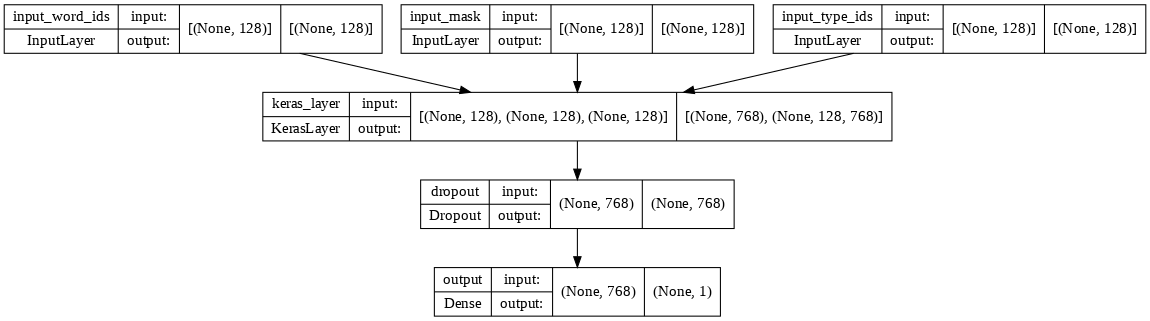

In [18]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

In [19]:
# Train model
epochs = 4
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/4
306/306 [==============================] - 282s 865ms/step - loss: 0.1859 - binary_accuracy: 0.9287 - val_loss: 0.1326 - val_binary_accuracy: 0.9604
Epoch 2/4
306/306 [==============================] - 266s 868ms/step - loss: 0.1076 - binary_accuracy: 0.9590 - val_loss: 0.1397 - val_binary_accuracy: 0.9625
Epoch 3/4
306/306 [==============================] - 267s 869ms/step - loss: 0.0625 - binary_accuracy: 0.9780 - val_loss: 0.1577 - val_binary_accuracy: 0.9583
Epoch 4/4
306/306 [==============================] - 266s 867ms/step - loss: 0.0261 - binary_accuracy: 0.9920 - val_loss: 0.2156 - val_binary_accuracy: 0.9510


## Step 11: Evaluate the BERT Text Classification Model

In [20]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

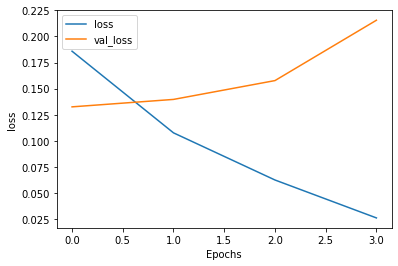

In [21]:
plot_graphs(history, 'loss')

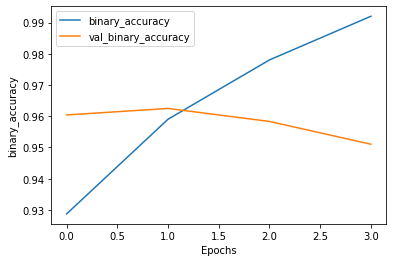

In [22]:
plot_graphs(history, 'binary_accuracy')

The model is overfitting. We need to tackle the problem later on.

In [26]:
sample_examples = ["you are mean", "I love sexy women", "I like you", "fuck you" ]
test_data = tf.data.Dataset.from_tensor_slices((sample_examples, [0]*len(sample_examples)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
threshold = 0.5
['Toxic' if pred >=threshold else 'Sincere' for pred in preds]

['Sincere', 'Toxic', 'Sincere', 'Toxic']